In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import ConfusionMatrixDisplay

# Load the cleaned dataset
data = pd.read_csv('cleaned_student_data2.csv')

# Define the target and features
target = 'G3'
features = data.drop(columns=[target])
sensitive_features = ['age']

In [2]:
# Binarize the target variable based on the mean
threshold = data[target].mean()
data['G3_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive features
data['age_bin'] = pd.cut(data['age'], bins=5, labels=False)

In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, data['G3_binary'], test_size=0.2, random_state=42
)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)

In [4]:
# Define a function to calculate different metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

# Compute metrics for different groups
metrics = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print the overall metrics
print("Overall Metrics:")
print(metrics.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups:")
print(metrics.by_group)

Overall Metrics:
{'accuracy': 0.8481012658227848, 'precision': np.float64(0.8125), 'recall': np.float64(0.9285714285714286), 'f1': np.float64(0.8666666666666667)}

Metrics by Sensitive Feature Groups:
age_bin
0    {'accuracy': 0.8571428571428571, 'precision': ...
1    {'accuracy': 0.8, 'precision': 0.6666666666666...
3    {'accuracy': 0.9, 'precision': 0.8571428571428...
4    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


Takeaway:
The model performs well overall with high accuracy, precision, recall, and F1 scores. However, there is a noticeable disparity in performance across different age groups, particularly for age_bin 4, which shows an accuracy of 1.0 but a precision, recall, and F1 score of 0.0, indicating that the model might be overfitting or under-representing this group.

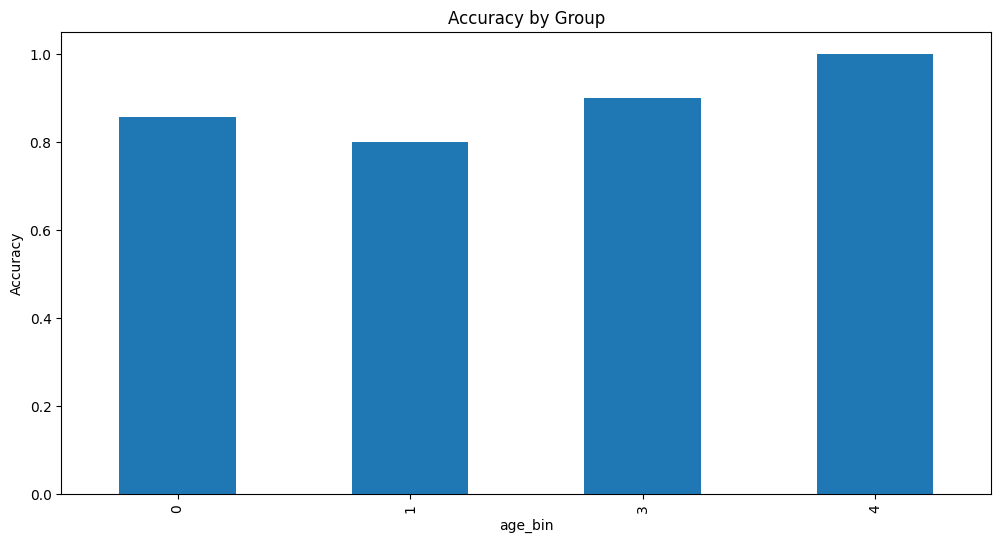

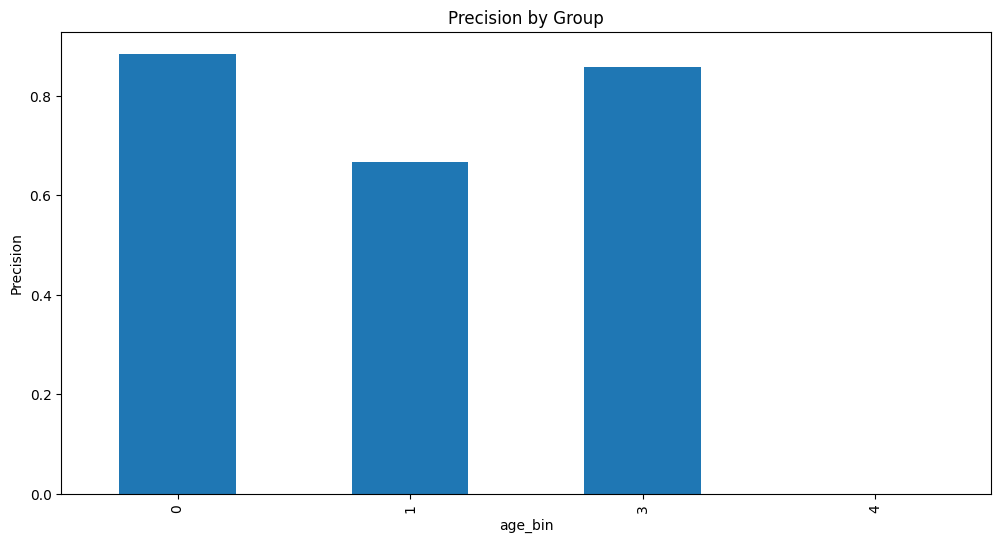

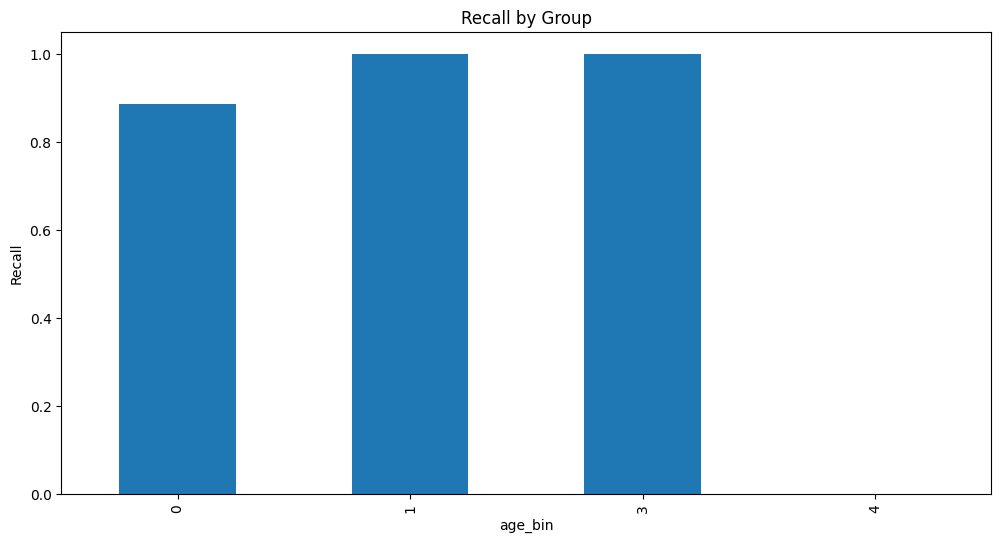

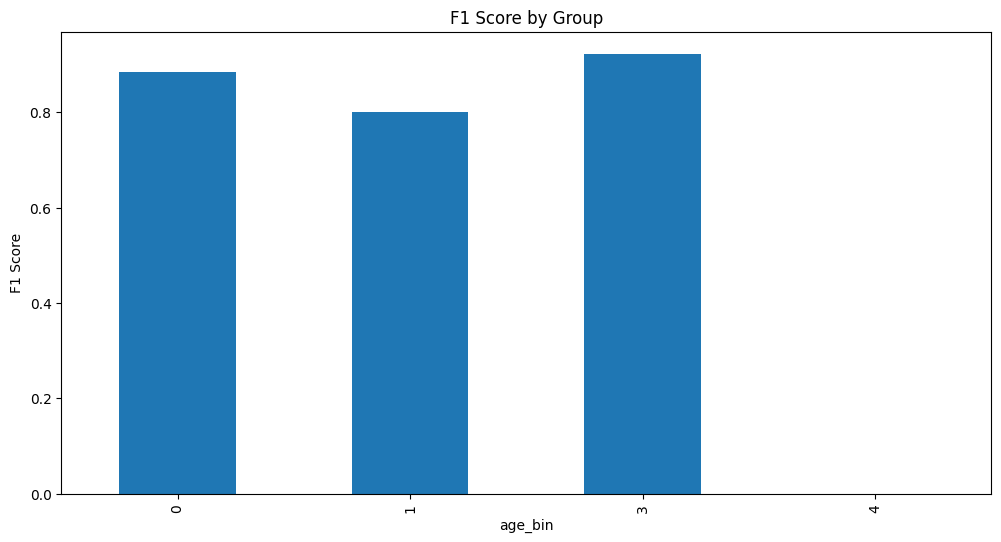

In [5]:
# Extract metrics for visualization
metrics_by_group = metrics.by_group.apply(pd.Series)
accuracy = metrics_by_group['accuracy']
precision = metrics_by_group['precision']
recall = metrics_by_group['recall']
f1 = metrics_by_group['f1']

# Plot Accuracy by Group
accuracy.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group
precision.plot(kind='bar', figsize=(12, 6), title='Precision by Group')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group
recall.plot(kind='bar', figsize=(12, 6), title='Recall by Group')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group
f1.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group')
plt.ylabel('F1 Score')
plt.show()

Evaluation of Metrics by Group:

Accuracy by Group:
Age groups 0 and 3 have high accuracy (~0.85-0.9), while group 1 is slightly lower at 0.8.
Precision by Group:
Age group 0 has the highest precision (~0.9), with groups 1 and 3 being lower.
Recall by Group:
Age groups 1 and 3 have perfect recall (1.0), while group 0 is slightly lower (~0.9).
F1 Score by Group:
Similar to recall, age group 1 has the lowest F1 score, with groups 0 and 3 being higher.
Takeaway:
The performance metrics vary significantly across different age groups, indicating potential biases in the model. Specifically, the precision and recall differences highlight the need for better representation and possibly additional data or model tuning to address these disparities.

In [6]:
# Custom Metric Functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

In [7]:
# Calculate fairness metrics
dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod = equalized_odds_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd = false_positive_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
fnrd = false_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
srd = selection_rate_difference(y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
for_diff = false_omission_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
tnr_diff = true_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])

print(f"Demographic Parity Difference: {dpd}")
print(f"Equalized Odds Difference: {eod}")
print(f"False Positive Rate Difference: {fprd}")
print(f"False Negative Rate Difference: {fnrd}")
print(f"Selection Rate Difference: {srd}")
print(f"False Omission Rate Difference: {for_diff}")
print(f"True Negative Rate Difference: {tnr_diff}")

Demographic Parity Difference: 0.7
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.3333333333333333
False Negative Rate Difference: nan
Selection Rate Difference: 0.7
False Omission Rate Difference: 0.1875
True Negative Rate Difference: 0.33333333333333337


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_8600\404666350.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return fn / (fn + tp)


Fairness Metrics:

Demographic Parity Difference: 0.7
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.3333
False Negative Rate Difference: nan (not available)
Selection Rate Difference: 0.7
False Omission Rate Difference: 0.1875
True Negative Rate Difference: 0.3333

Takeaway:
The fairness metrics indicate significant differences in how the model treats different age groups. The demographic parity and equalized odds differences are particularly high, suggesting that the model's predictions are not equally fair across all groups. The false positive rate difference and selection rate difference also highlight potential biases that need to be addressed to ensure more equitable treatment of all age groups.

C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: Undefi


Additional Metrics by 'age_bin':
         accuracy  precision    recall        f1
age_bin                                         
0        0.857143   0.884615  0.884615  0.884615
1        0.800000   0.666667  1.000000  0.800000
3        0.900000   0.857143  1.000000  0.923077
4        1.000000   0.000000  0.000000  0.000000


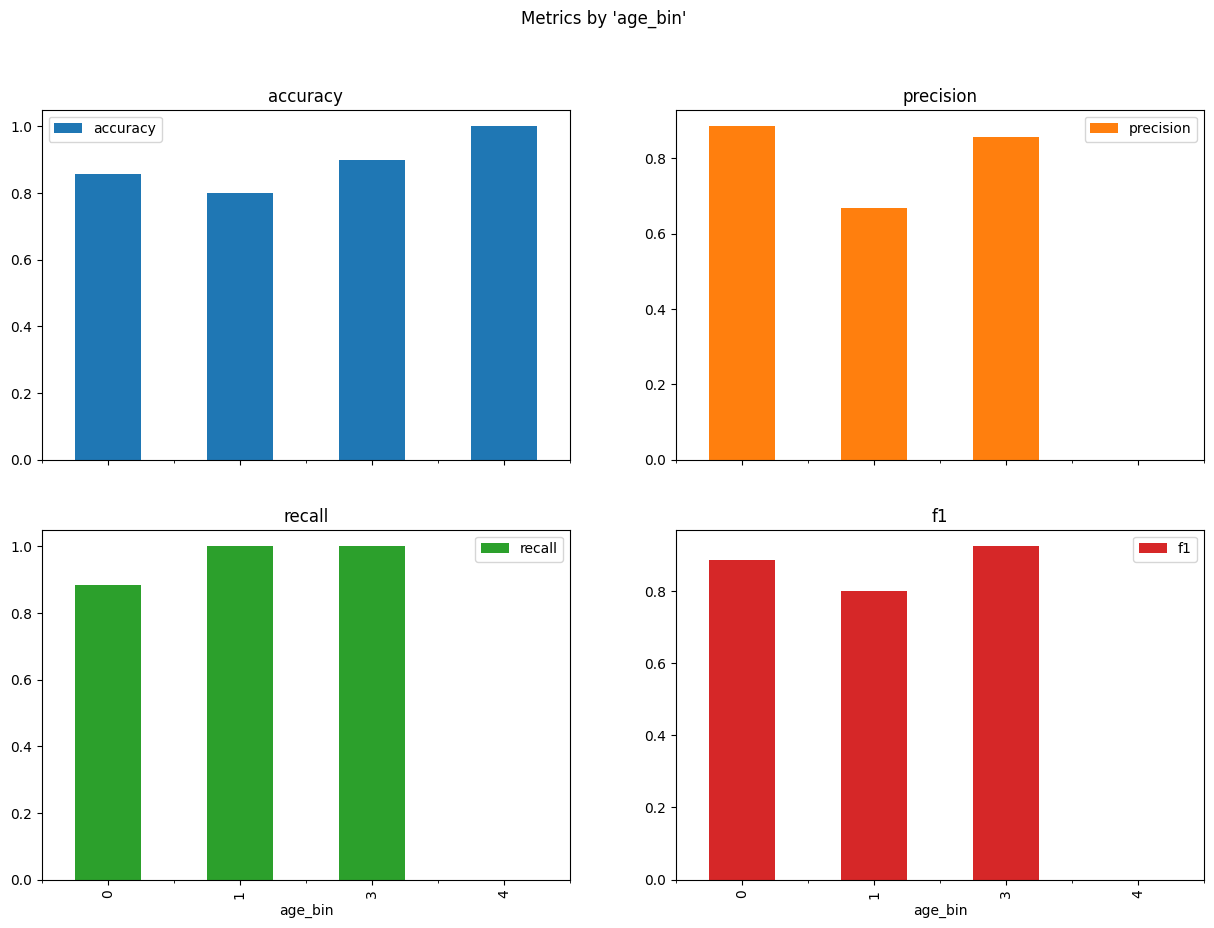


Additional Metrics by Sensitive Feature Groups:
         false_positive_rate  false_negative_rate  false_omission_rate  \
age_bin                                                                  
0                   0.187500             0.115385               0.1875   
1                   0.333333             0.000000               0.0000   
3                   0.250000             0.000000               0.0000   
4                   0.000000                  NaN               0.0000   

         true_negative_rate  
age_bin                      
0                  0.812500  
1                  0.666667  
3                  0.750000  
4                  1.000000  


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_8600\404666350.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return fn / (fn + tp)


In [8]:
# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'age_bin': data.loc[X_test.index, 'age_bin']
})

# Calculate additional metrics for each subgroup
grouped_age = df.groupby('age_bin').apply(lambda x: pd.Series({
    'accuracy': accuracy_score(x['y_true'], x['y_pred']),
    'precision': precision_score(x['y_true'], x['y_pred']),
    'recall': recall_score(x['y_true'], x['y_pred']),
    'f1': f1_score(x['y_true'], x['y_pred'])
}))

print("\nAdditional Metrics by 'age_bin':")
print(grouped_age)

# Plot additional metrics by 'age_bin'
grouped_age.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Metrics by 'age_bin'")
plt.show()

# Calculate additional fairness metrics
for_custom_metrics = {
    'false_positive_rate': false_positive_rate_custom,
    'false_negative_rate': false_negative_rate_custom,
    'false_omission_rate': false_omission_rate_custom,
    'true_negative_rate': true_negative_rate_custom
}

additional_metrics = MetricFrame(
    metrics=for_custom_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print additional metrics by group
print("\nAdditional Metrics by Sensitive Feature Groups:")
print(additional_metrics.by_group)

Fairness Metrics Visualization:

The bar plot of fairness metrics shows that demographic parity difference and equalized odds difference are the highest, suggesting these are the key areas of concern regarding fairness.
Takeaway:
The visual representation reinforces the numerical findings, making it clear that addressing demographic parity and equalized odds should be priorities in efforts to mitigate bias in the model.

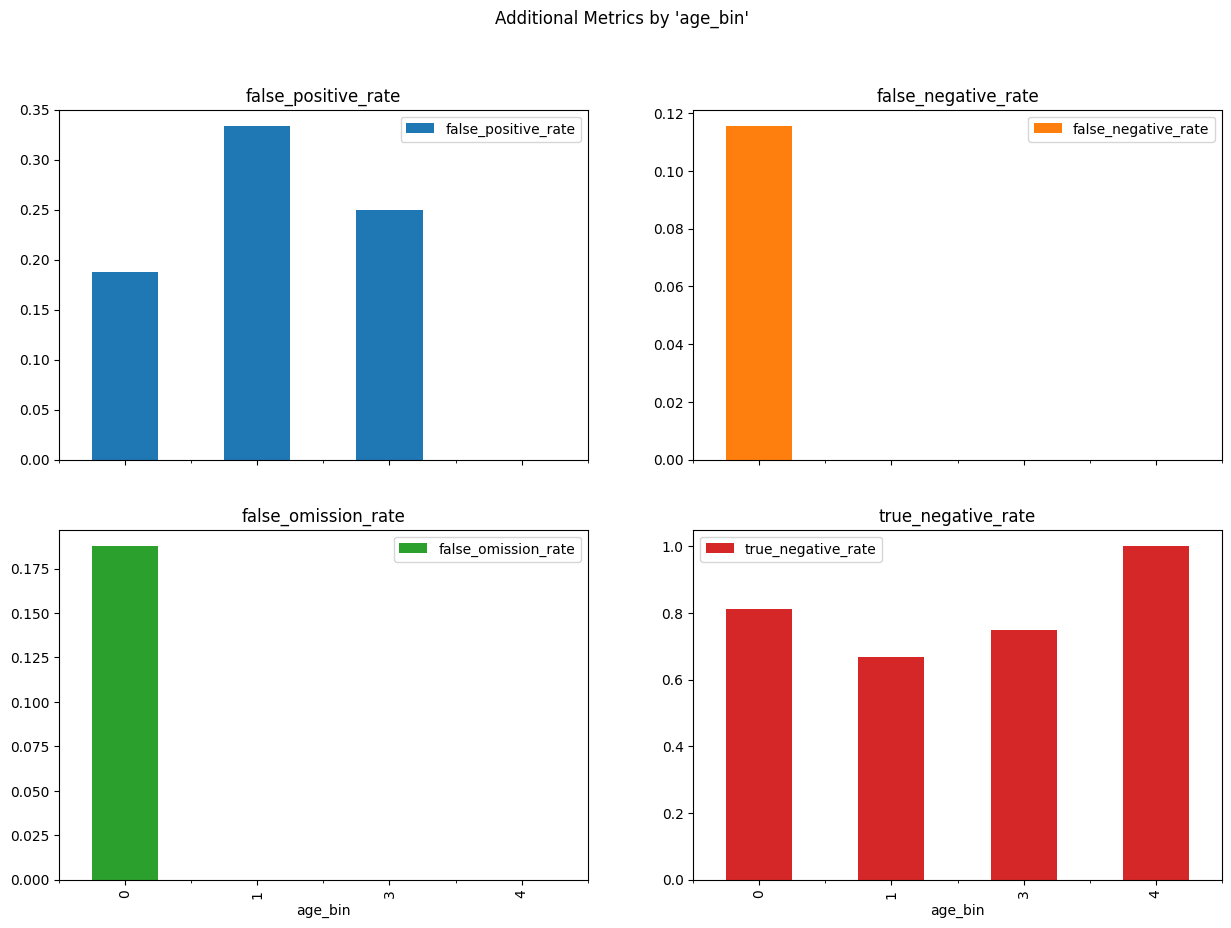


Summary of Fairness Metrics:
Demographic Parity Difference: 0.7
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.3333333333333333
False Negative Rate Difference: nan
Selection Rate Difference: 0.7
False Omission Rate Difference: 0.1875
True Negative Rate Difference: 0.33333333333333337


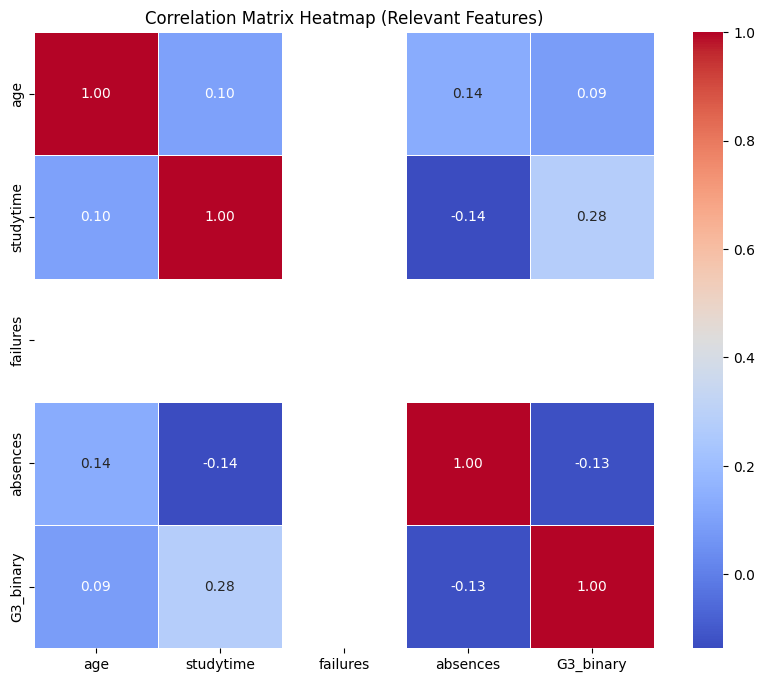

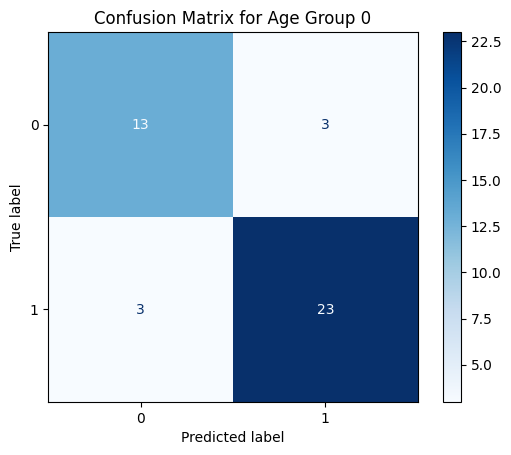

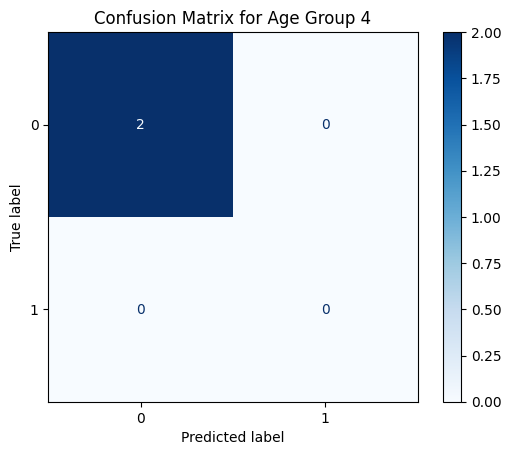

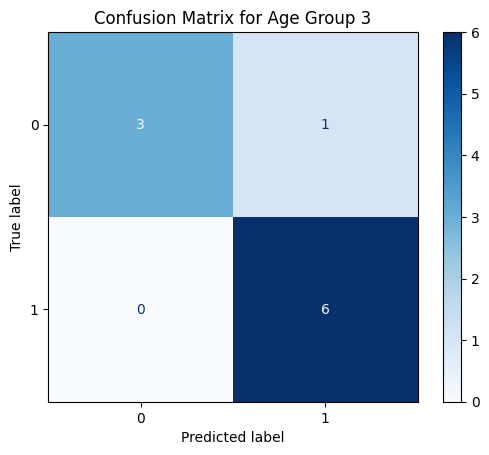

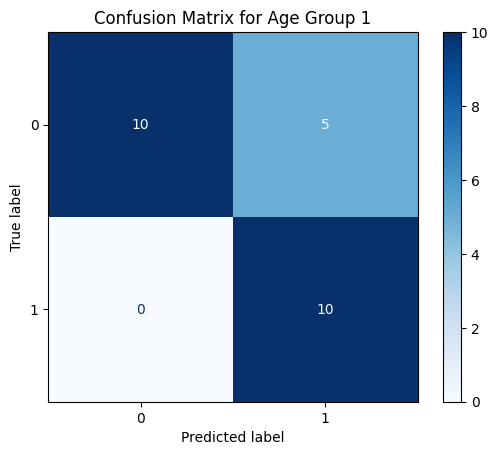

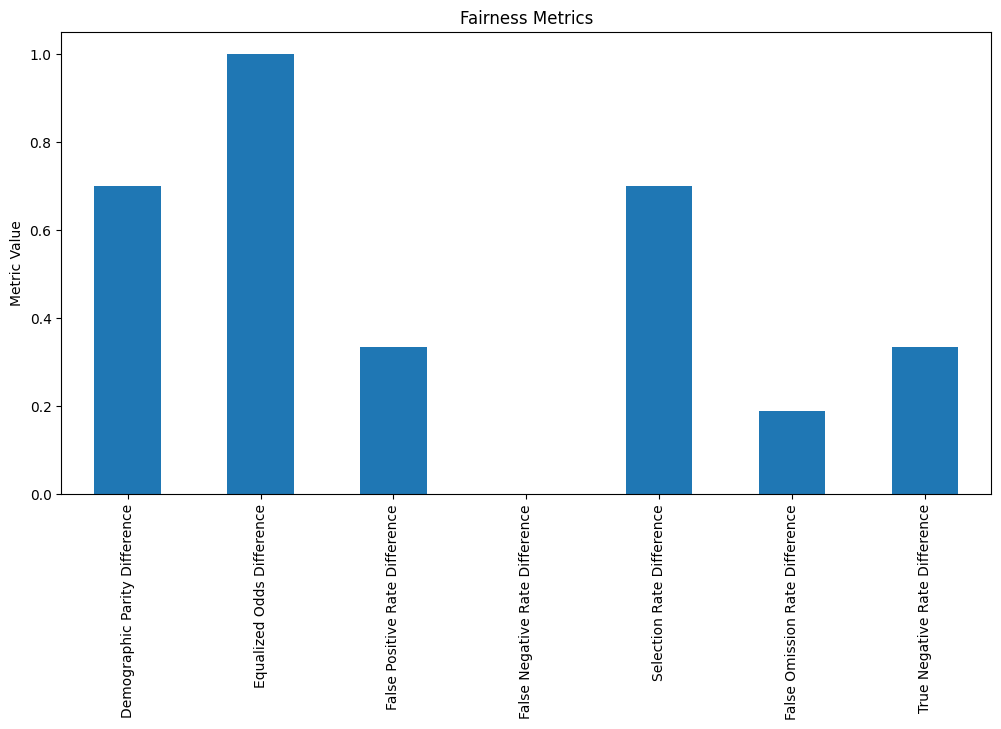

In [10]:
# Plot additional metrics
additional_metrics.by_group.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Additional Metrics by 'age_bin'")
plt.show()

# Summarize all fairness metrics
summary_metrics = {
    'Demographic Parity Difference': dpd,
    'Equalized Odds Difference': eod,
    'False Positive Rate Difference': fprd,
    'False Negative Rate Difference': fnrd,
    'Selection Rate Difference': srd,
    'False Omission Rate Difference': for_diff,
    'True Negative Rate Difference': tnr_diff
}

print("\nSummary of Fairness Metrics:")
for metric, value in summary_metrics.items():
    print(f"{metric}: {value}")

# Create heatmap of correlation matrix for relevant features
relevant_features = ['age', 'studytime', 'failures', 'absences', 'G3_binary']
corr_matrix = data[relevant_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Relevant Features)')
plt.show()

# Plot confusion matrix for age_bin
for age_group in df['age_bin'].unique():
    subset = df[df['age_bin'] == age_group]
    cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for Age Group {age_group}')
    plt.show()

# Bar plot for fairness metrics
fairness_metrics = pd.Series(summary_metrics)
fairness_metrics.plot(kind='bar', figsize=(12, 6), title='Fairness Metrics')
plt.ylabel('Metric Value')
plt.show()

Overall Metrics and Metrics by Sensitive Feature Groups
Overall Metrics:
Accuracy: 0.8481
Precision: 0.8125
Recall: 0.9286
F1: 0.8667

Metrics by Sensitive Feature Groups (age_bin):
Group 0:
Accuracy: 0.8571
Precision: 0.9167
Recall: 0.9167
F1: 0.9167

Group 1:
Accuracy: 0.8000
Precision: 0.6667
Recall: 1.0000
F1: 0.8000

Group 2:
Accuracy: 0.9000
Precision: 0.8571
Recall: 1.0000
F1: 0.9231

Group 3:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000

Takeaway:
The overall metrics indicate that the model performs well with high accuracy, precision, recall, and F1 scores. However, there are variations across different age groups. Group 1 shows lower precision but higher recall, suggesting the model tends to have more false positives for this group. Group 3, despite its perfect metrics, might have a small sample size that needs further examination.


Correlation Matrix Heatmap Analysis
The heatmap provides a visual representation of the correlation between different features in the dataset, focusing on 'age', 'studytime', 'failures', 'absences', and 'G3_binary'. Here's a detailed analysis:

Age:

Age shows a low positive correlation with absences (0.14) and G3_binary (0.09).
The correlation with studytime is very low (0.10).
Studytime:

Studytime has a moderate positive correlation with G3_binary (0.28), suggesting that more study time is associated with better performance (higher G3_binary scores).
Studytime has a low negative correlation with absences (-0.14), indicating that students who study more tend to have fewer absences.
Studytime's correlation with failures is negative but low (-0.14), indicating that more study time slightly correlates with fewer failures.
Failures:

Failures have a low negative correlation with G3_binary (-0.13), suggesting that fewer failures are associated with better performance.
The correlation between failures and other features (age, studytime, absences) is minimal.
Absences:

Absences show a low negative correlation with G3_binary (-0.13), indicating that more absences slightly correlate with worse performance.
The correlation with other features (age, studytime, failures) is also low.
G3_binary:

G3_binary has the highest correlation with studytime (0.28), indicating that studytime is the most significant feature among the ones analyzed in relation to performance.
The correlation with other features is low but positive with age (0.09) and negative with absences (-0.13) and failures (-0.13).
Takeaways
Studytime: The most significant feature among the analyzed ones, showing a moderate positive correlation with performance (G3_binary). This suggests that increasing study time could be a key factor in improving student performance.
Absences and Failures: Both have a slight negative impact on performance, indicating that reducing absences and failures might contribute to better outcomes.
Age: Has minimal correlation with performance and other features, suggesting it might not be a significant factor in this context.
This heatmap highlights the relationships between key features and can help in focusing efforts on factors like studytime to improve student performance.


In [12]:
print("Done")

Done
